In [142]:
import pandas as pd

file_path = "Base_Test_2500pts.xlsx"
data = pd.ExcelFile(file_path)

In [143]:
sheet_name = data.sheet_names[0]
df = data.parse(sheet_name)

In [144]:
df["Date"] = pd.to_datetime(df["Date"])
df["Date"]

0      2015-02-12 00:00:00+00:00
1      2015-02-13 00:00:00+00:00
2      2015-02-17 00:00:00+00:00
3      2015-02-18 00:00:00+00:00
4      2015-02-19 00:00:00+00:00
                  ...           
2510   2025-02-05 00:00:00+00:00
2511   2025-02-06 00:00:00+00:00
2512   2025-02-07 00:00:00+00:00
2513   2025-02-10 00:00:00+00:00
2514   2025-02-11 00:00:00+00:00
Name: Date, Length: 2515, dtype: datetime64[ns, UTC]

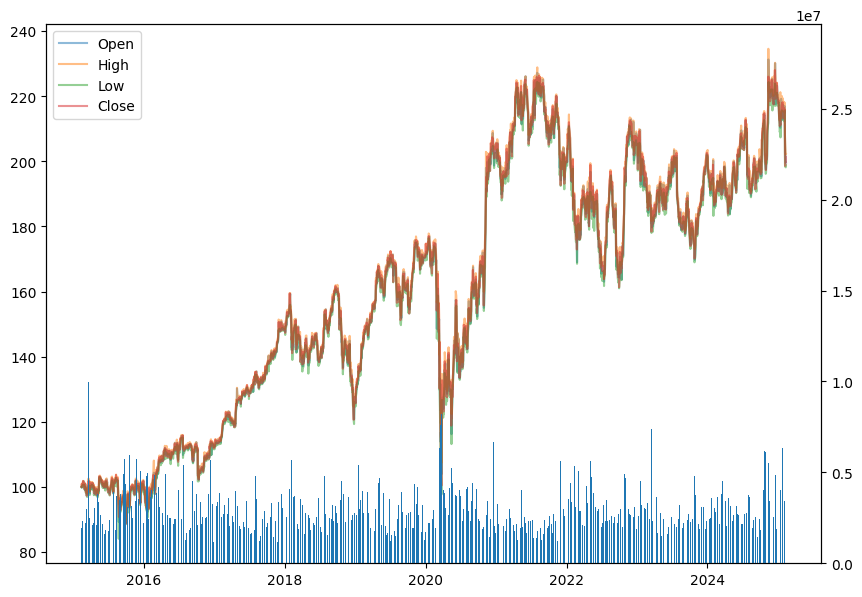

In [145]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 
ax2 = ax.twinx()
for col in df.columns[2:6] :
    ax.plot(df["Date"],df[col], label = col, alpha = 0.5)
    #ax.set_title(col)

ax.legend()
ax2.bar(df["Date"],df["Volume"])


fig.set_size_inches(10,7)
plt.show()

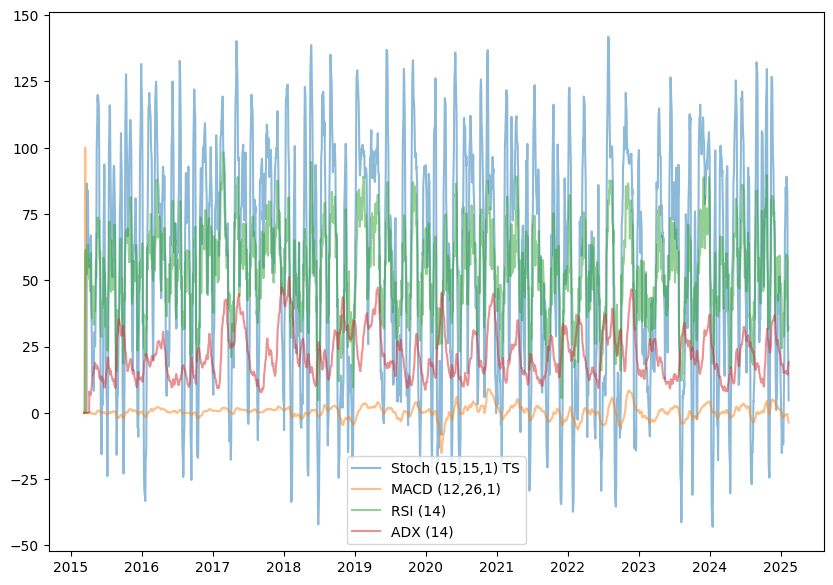

In [146]:
fig, ax = plt.subplots()
for col in df.columns[8:] :
    ax.plot(df["Date"],df[col], label = col, alpha = 0.5)
    #ax.set_title(col)

ax.legend()


fig.set_size_inches(10,7)
plt.show()

## Indicators comprehension

In [147]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Close Lissé (Lag<=2),"Stoch (15,15,1) TS","MACD (12,26,1)",RSI (14),ADX (14)
0,0,2015-02-12 00:00:00+00:00,100.000000,100.000000,100.000000,100.000000,1942140,NaN,NaN,NaN,NaN,NaN
1,1,2015-02-13 00:00:00+00:00,99.758454,100.917874,99.758454,100.850242,1970287,NaN,NaN,NaN,NaN,NaN
2,2,2015-02-17 00:00:00+00:00,100.550725,100.884058,100.154589,100.483092,2298193,NaN,NaN,NaN,NaN,NaN
3,3,2015-02-18 00:00:00+00:00,100.705314,101.400966,100.541063,101.082126,2267560,NaN,NaN,NaN,NaN,NaN
4,4,2015-02-19 00:00:00+00:00,100.743961,101.439614,100.502415,101.159420,1961666,NaN,NaN,NaN,NaN,NaN


In [148]:
import pandas as pd
import numpy as np

def calculate_adx(df, n=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Step 1: Calculate True Range (TR)
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Step 2: Calculate +DM and -DM
    up_move = high - high.shift(1)
    down_move = low.shift(1) - low
    
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
    
    # Step 3: Smooth TR, +DM, -DM
    tr_smooth = tr.rolling(window=n).sum()
    plus_dm_smooth = pd.Series(plus_dm).rolling(window=n).sum()
    minus_dm_smooth = pd.Series(minus_dm).rolling(window=n).sum()

    # Step 4: Calculate +DI and -DI
    plus_di = 100 * (plus_dm_smooth / tr_smooth)
    minus_di = 100 * (minus_dm_smooth / tr_smooth)

    # Step 5: Calculate DX
    dx = (np.abs(plus_di - minus_di) / (plus_di + minus_di)) * 100

    # Step 6: Calculate ADX
    # First ADX value is the mean of the first `n` DX values
    adx = dx.rolling(window=n).mean()

    # Subsequent ADX values use Wilder's smoothing method
    adx = adx.ewm(alpha=1/n, adjust=False).mean()

    # Add to DataFrame
    df['+DI'] = plus_di
    df['-DI'] = minus_di
    df['ADX'] = adx

    return df

# Example usage:
df = calculate_adx(df, n=14)
df.tail()


,Unnamed: 0,Date,Open,High,Low,Close,Volume,Close Lissé (Lag<=2),"Stoch (15,15,1) TS","MACD (12,26,1)",RSI (14),ADX (14),+DI,-DI,ADX
2510,2510,2025-02-05 00:00:00+00:00,215.990338,216.623188,211.835749,214.830918,4596931,574.330761,72.531895,-0.500833,54.938366,14.384642,24.139278,16.805873,21.796141
2511,2511,2025-02-06 00:00:00+00:00,207.729469,207.961353,199.207729,202.724638,12185282,571.668134,48.487249,-1.471943,34.258066,15.642882,14.615414,32.716633,21.759932
2512,2512,2025-02-07 00:00:00+00:00,204.830918,206.183575,198.429952,198.570048,6696581,569.017851,29.149208,-2.547430,30.848792,16.882676,10.761476,32.280091,21.960705
2513,2513,2025-02-10 00:00:00+00:00,199.565217,202.082126,198.144928,201.468599,6628210,0.000000,15.049828,-3.129794,32.002608,18.105342,9.737755,33.163106,22.418857
2514,2514,2025-02-11 00:00:00+00:00,199.584541,202.260870,198.821256,199.942029,3077514,0.000000,4.682268,-3.672173,32.194798,19.169246,9.839280,31.910554,23.073384


In [149]:
import pandas as pd
import numpy as np

def calculate_rsi(df, n=14):
    close = df['Close']

    # Step 1: Calculate Change
    delta = close.diff()

    # Step 2: Separate Gains and Losses
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # Step 3: Calculate Average Gain and Loss using Wilder's Smoothing
    gain_smooth = pd.Series(gain).rolling(window=n).mean()
    loss_smooth = pd.Series(loss).rolling(window=n).mean()

    # First average gain/loss is the simple average of the first n periods
    gain_smooth.iloc[n] = gain[:n].mean()
    loss_smooth.iloc[n] = loss[:n].mean()

    # Calculate the rest using Wilder's smoothing
    for i in range(n + 1, len(gain)):
        gain_smooth.iloc[i] = (gain_smooth.iloc[i - 1] * (n - 1) + gain[i]) / n
        loss_smooth.iloc[i] = (loss_smooth.iloc[i - 1] * (n - 1) + loss[i]) / n

    # Step 4: Calculate RS
    rs = gain_smooth / loss_smooth

    # Step 5: Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    # Add to DataFrame
    df['RSI'] = rsi

    return df

# Example usage:
df = calculate_rsi(df, n=14)
df.tail()


,Unnamed: 0,Date,Open,High,Low,Close,Volume,Close Lissé (Lag<=2),"Stoch (15,15,1) TS","MACD (12,26,1)",RSI (14),ADX (14),+DI,-DI,ADX,RSI
2510,2510,2025-02-05 00:00:00+00:00,215.990338,216.623188,211.835749,214.830918,4596931,574.330761,72.531895,-0.500833,54.938366,14.384642,24.139278,16.805873,21.796141,47.861829
2511,2511,2025-02-06 00:00:00+00:00,207.729469,207.961353,199.207729,202.724638,12185282,571.668134,48.487249,-1.471943,34.258066,15.642882,14.615414,32.716633,21.759932,32.163749
2512,2512,2025-02-07 00:00:00+00:00,204.830918,206.183575,198.429952,198.570048,6696581,569.017851,29.149208,-2.547430,30.848792,16.882676,10.761476,32.280091,21.960705,28.686492
2513,2513,2025-02-10 00:00:00+00:00,199.565217,202.082126,198.144928,201.468599,6628210,0.000000,15.049828,-3.129794,32.002608,18.105342,9.737755,33.163106,22.418857,34.043989
2514,2514,2025-02-11 00:00:00+00:00,199.584541,202.260870,198.821256,199.942029,3077514,0.000000,4.682268,-3.672173,32.194798,19.169246,9.839280,31.910554,23.073384,32.652662


In [150]:
import pandas as pd

def calculate_macd(df, short=12, long=26, signal=9):
    close = df['Close']
    
    # Step 1 & 2: Calculate Short-Term and Long-Term EMA
    ema_short = close.ewm(span=short, adjust=False).mean()
    ema_long = close.ewm(span=long, adjust=False).mean()

    # Step 3: Calculate MACD Line
    macd_line = ema_short - ema_long

    # Step 4: Calculate Signal Line
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()

    # Step 5: Calculate MACD Histogram
    macd_histogram = macd_line - signal_line

    # Add to DataFrame
    df['MACD'] = macd_line
    df['Signal_Line'] = signal_line
    df['MACD_Histogram'] = macd_histogram

    return df

# Example usage:
df = calculate_macd(df, short=12, long=26, signal=9)
df.tail()


,Unnamed: 0,Date,Open,High,Low,Close,Volume,Close Lissé (Lag<=2),"Stoch (15,15,1) TS","MACD (12,26,1)",RSI (14),ADX (14),+DI,-DI,ADX,RSI,MACD,Signal_Line,MACD_Histogram
2510,2510,2025-02-05 00:00:00+00:00,215.990338,216.623188,211.835749,214.830918,4596931,574.330761,72.531895,-0.500833,54.938366,14.384642,24.139278,16.805873,21.796141,47.861829,-0.500833,-0.677757,0.176923
2511,2511,2025-02-06 00:00:00+00:00,207.729469,207.961353,199.207729,202.724638,12185282,571.668134,48.487249,-1.471943,34.258066,15.642882,14.615414,32.716633,21.759932,32.163749,-1.471943,-0.836594,-0.635349
2512,2512,2025-02-07 00:00:00+00:00,204.830918,206.183575,198.429952,198.570048,6696581,569.017851,29.149208,-2.547430,30.848792,16.882676,10.761476,32.280091,21.960705,28.686492,-2.547430,-1.178761,-1.368669
2513,2513,2025-02-10 00:00:00+00:00,199.565217,202.082126,198.144928,201.468599,6628210,0.000000,15.049828,-3.129794,32.002608,18.105342,9.737755,33.163106,22.418857,34.043989,-3.129794,-1.568968,-1.560826
2514,2514,2025-02-11 00:00:00+00:00,199.584541,202.260870,198.821256,199.942029,3077514,0.000000,4.682268,-3.672173,32.194798,19.169246,9.839280,31.910554,23.073384,32.652662,-3.672173,-1.989609,-1.682564


In [152]:
import pandas as pd

def calculate_stochastic(df, k_period=15, d_period=15, k_smoothing=1):
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # Step 1: Calculate %K
    lowest_low = low.rolling(window=k_period).min()
    highest_high = high.rolling(window=k_period).max()
    k = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    
    # Step 2: Apply Smoothing to %K if necessary
    if k_smoothing > 1:
        k = k.rolling(window=k_smoothing).mean()

    # Step 3: Calculate %D as EMA of %K
    d = k.ewm(span=d_period, adjust=False).mean()

    # Add to DataFrame
    df['%K'] = k
    df['%D'] = d

    return df

# Example usage:
df = calculate_stochastic(df, k_period=15, d_period=15, k_smoothing=1)
df.tail()


,Unnamed: 0,Date,Open,High,Low,Close,Volume,Close Lissé (Lag<=2),"Stoch (15,15,1) TS","MACD (12,26,1)",...,ADX (14),+DI,-DI,ADX,RSI,MACD,Signal_Line,MACD_Histogram,%K,%D
2510,2510,2025-02-05 00:00:00+00:00,215.990338,216.623188,211.835749,214.830918,4596931,574.330761,72.531895,-0.500833,...,14.384642,24.139278,16.805873,21.796141,47.861829,-0.500833,-0.677757,0.176923,53.379549,52.548080
2511,2511,2025-02-06 00:00:00+00:00,207.729469,207.961353,199.207729,202.724638,12185282,571.668134,48.487249,-1.471943,...,15.642882,14.615414,32.716633,21.759932,32.163749,-1.471943,-0.836594,-0.635349,16.890951,48.090939
2512,2512,2025-02-07 00:00:00+00:00,204.830918,206.183575,198.429952,198.570048,6696581,569.017851,29.149208,-2.547430,...,16.882676,10.761476,32.280091,21.960705,28.686492,-2.547430,-1.178761,-1.368669,0.648624,42.160650
2513,2513,2025-02-10 00:00:00+00:00,199.565217,202.082126,198.144928,201.468599,6628210,0.000000,15.049828,-3.129794,...,18.105342,9.737755,33.163106,22.418857,34.043989,-3.129794,-1.568968,-1.560826,15.187638,38.789023
2514,2514,2025-02-11 00:00:00+00:00,199.584541,202.260870,198.821256,199.942029,3077514,0.000000,4.682268,-3.672173,...,19.169246,9.839280,31.910554,23.073384,32.652662,-3.672173,-1.989609,-1.682564,8.427730,34.993861


In [153]:
def calculate_smoothed_close(df, period=2):
    """
    Calculate the smoothed close using EMA with minimal lag.
    """
    # Calculate EMA with the given period
    smoothed_close = df['Close'].ewm(span=period, adjust=False).mean()
    df['Close_Lissé'] = smoothed_close
    
    return df
# Example usage:
df = calculate_smoothed_close(df, period=2)
df.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Close Lissé (Lag<=2),"Stoch (15,15,1) TS","MACD (12,26,1)",...,+DI,-DI,ADX,RSI,MACD,Signal_Line,MACD_Histogram,%K,%D,Close_Lissé
2510,2510,2025-02-05 00:00:00+00:00,215.990338,216.623188,211.835749,214.830918,4596931,574.330761,72.531895,-0.500833,...,24.139278,16.805873,21.796141,47.861829,-0.500833,-0.677757,0.176923,53.379549,52.548080,215.135272
2511,2511,2025-02-06 00:00:00+00:00,207.729469,207.961353,199.207729,202.724638,12185282,571.668134,48.487249,-1.471943,...,14.615414,32.716633,21.759932,32.163749,-1.471943,-0.836594,-0.635349,16.890951,48.090939,206.861516
2512,2512,2025-02-07 00:00:00+00:00,204.830918,206.183575,198.429952,198.570048,6696581,569.017851,29.149208,-2.547430,...,10.761476,32.280091,21.960705,28.686492,-2.547430,-1.178761,-1.368669,0.648624,42.160650,201.333871
2513,2513,2025-02-10 00:00:00+00:00,199.565217,202.082126,198.144928,201.468599,6628210,0.000000,15.049828,-3.129794,...,9.737755,33.163106,22.418857,34.043989,-3.129794,-1.568968,-1.560826,15.187638,38.789023,201.423690
2514,2514,2025-02-11 00:00:00+00:00,199.584541,202.260870,198.821256,199.942029,3077514,0.000000,4.682268,-3.672173,...,9.839280,31.910554,23.073384,32.652662,-3.672173,-1.989609,-1.682564,8.427730,34.993861,200.435916


## Network

In [154]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Paths
data_dir = './data'  # Path to your main data directory
# The main directory should contain both 'positive' and 'negative' folders
train_dir = data_dir

# Parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Datasets
from torch.utils.data import random_split, ConcatDataset

# Load datasets separately
# Dataset will automatically identify 'positive' and 'negative' as classes
full_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'], is_valid_file=lambda x: x.endswith('.png'))

# Check class-to-index mapping
print('Class to index mapping:', full_dataset.class_to_idx)
# Dataset will automatically identify 'positive' and 'negative' as classes
full_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'], is_valid_file=lambda x: x.endswith('.png'))

Class to index mapping: {'negative': 0, 'positive': 1}


In [155]:
# Split into training and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [156]:
# Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [157]:
from collections import Counter
from tqdm import tqdm

# Display dataset information
labels = [label for _, label in train_loader.dataset]
label_counts = Counter(labels)
num_samples = len(labels)

print(f"Total training samples: {num_samples}")
print("Class distribution:")
for class_idx, count in label_counts.items():
    print(f"Class {class_idx}: {count} samples")

Total training samples: 18882
Class distribution:
Class 0: 9750 samples
Class 1: 9132 samples


In [158]:
from tqdm import tqdm

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    epoch_loss = 0.0
    correct = 0
    total = 0
    model.train()

    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({'Batch': batch_idx + 1, 'Loss': loss.item()})

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print('Training complete.')

Epoch 1/10


Training:   0%|          | 0/591 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.7063, Accuracy: 51.60%
Epoch 2/10


Epoch 2/10, Loss: 0.6863, Accuracy: 54.46%
Epoch 3/10


KeyboardInterrupt: 